# Computer Vision Assignment #3 2016-16466 윤웅상

In [108]:
import numpy as np
import math
import matplotlib.image as pimg
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import time
from pylab import rcParams
import cv2 as cv

rcParams['figure.figsize'] = 13, 10
image_buildings_1=Image.open('image_buildings_1.jpg')
image_buildings_2=Image.open('image_buildings_2.jpg')
image_buildings_3=Image.open('image_buildings_3.jpg')

과제 3에서는 3개의 overlapping image를 이용해서 하나의 panorama 이미지를 만들어본다. 이를 만들기 위해서는 크게 다음과 같은 과정을 거친다.

1. SIFT 알고리즘을 이용한 scale invariant feature detection
2. ANN 알고리즘과 각 feature들의 descriptor를 이용하여 이미지들간의 feature을 매칭
3. RANSAC을 이용해 best fitting homograpy matrix를 구함
3. 1) matching되는 feature 4개를 구한 후 DLT 알고리즘을 이용해 homography matrix를 구함
3. 2) inliners수가 최대가 되도록 RANSAC을 반복하는데 반복 횟수에 adaptive measure을 사용
3. 3) 최대의 inliner feature들을 이용해 다시한번 DLT 알고리즘을 돌려서 homography matrix를 구함
4. homography matrix, backward warping 과 linear interpolation을 이용하여 이미지1, 3 변환
5. 변환된 이미지1,3을 기준이미지2와 연결하여 파노라마 이미지 생성


참고사항

1.다른 이미지를 사용하고 싶다면 이 문서 첫번째 cell의 image open 부분만 바꿔주면된다

2.기본적으로 변환된 이미지는 (400,800) 사이즈로 하였고, warping의 정도에 따라 당연히 범위를 벗어날 수 있는데 이는 잘라주도록 디자인하였다. 빌딩 이미지의 경우에는 warping의 수준이 해당 matrix size를 벗어나지 않았다.

3.모든 옵션을 구현하여서 최대한 많은 inliner들을 찾아낸 후 적절한 homography matrix를 도출한다

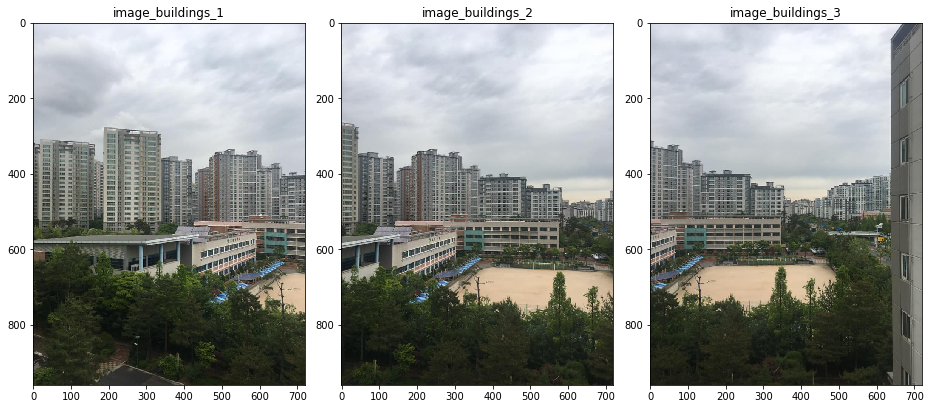

In [109]:
plt.subplot(131)
plt.title('image_buildings_1')
plt.imshow(image_buildings_1)
plt.subplot(132)
plt.title('image_buildings_2')
plt.imshow(image_buildings_2)
plt.subplot(133)
plt.title('image_buildings_3')
plt.imshow(image_buildings_3)
plt.tight_layout()

In [110]:
img_1=image_buildings_1.resize((256,256))
img_2=image_buildings_2.resize((256,256))
img_3=image_buildings_3.resize((256,256))

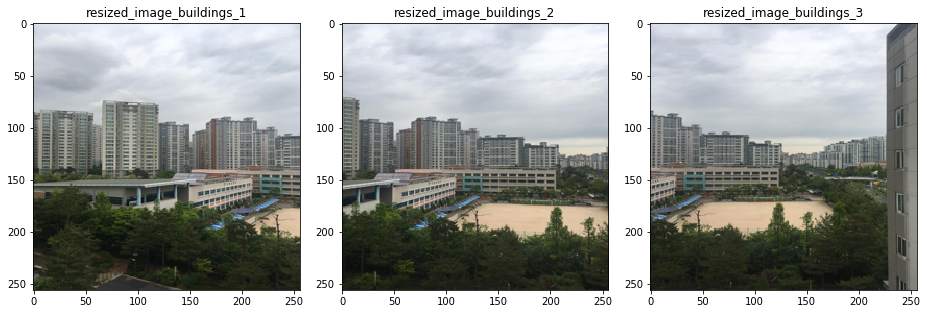

In [111]:
plt.subplot(131)
plt.title('resized_image_buildings_1')
plt.imshow(img_1)
plt.subplot(132)
plt.title('resized_image_buildings_2')
plt.imshow(img_2)
plt.subplot(133)
plt.title('resized_image_buildings_3')
plt.imshow(img_3)
plt.tight_layout()

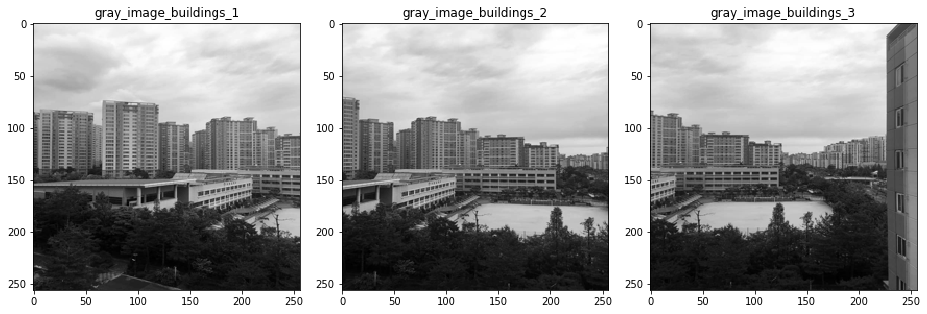

In [112]:
img_1_arr=np.array(img_1)
img_2_arr=np.array(img_2)
img_3_arr=np.array(img_3)
grey_img_1=np.round((img_1_arr[:,:,0]/3+img_1_arr[:,:,1]/3+img_1_arr[:,:,2]/3)).astype('uint8')
grey_img_2=np.round((img_2_arr[:,:,0]/3+img_2_arr[:,:,1]/3+img_2_arr[:,:,2]/3)).astype('uint8')
grey_img_3=np.round((img_3_arr[:,:,0]/3+img_3_arr[:,:,1]/3+img_3_arr[:,:,2]/3)).astype('uint8')

plt.subplot(131)
plt.title('gray_image_buildings_1')
plt.imshow(grey_img_1, cmap='gray')
plt.subplot(132)
plt.title('gray_image_buildings_2')
plt.imshow(grey_img_2, cmap='gray')
plt.subplot(133)
plt.title('gray_image_buildings_3')
plt.imshow(grey_img_3, cmap='gray')

plt.tight_layout()

In [113]:
sift=cv.SIFT_create(nfeatures=280, contrastThreshold=0.03, edgeThreshold=10, sigma=1.6)

k1,d1=sift.detectAndCompute(grey_img_1,None)
r1=cv.drawKeypoints(grey_img_1,k1,grey_img_1)

k2,d2=sift.detectAndCompute(grey_img_2,None)
r2=cv.drawKeypoints(grey_img_2,k2,grey_img_2)

k3,d3=sift.detectAndCompute(grey_img_3,None)
r3=cv.drawKeypoints(grey_img_3,k3,grey_img_3)

이미지당 280개의 feature을 detect 하도록 해주었다

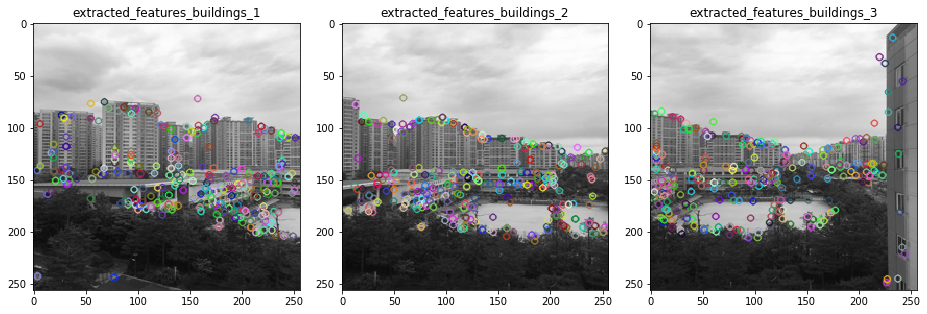

In [114]:
plt.subplot(131)
plt.title('extracted_features_buildings_1')
plt.imshow(r1)
plt.subplot(132)
plt.title('extracted_features_buildings_2')
plt.imshow(r2)
plt.subplot(133)
plt.title('extracted_features_buildings_3')
plt.imshow(r3)

plt.tight_layout()

ANN알고리즘을 이용하여 매칭을 찾았고 threshold는 0.7로 하였다

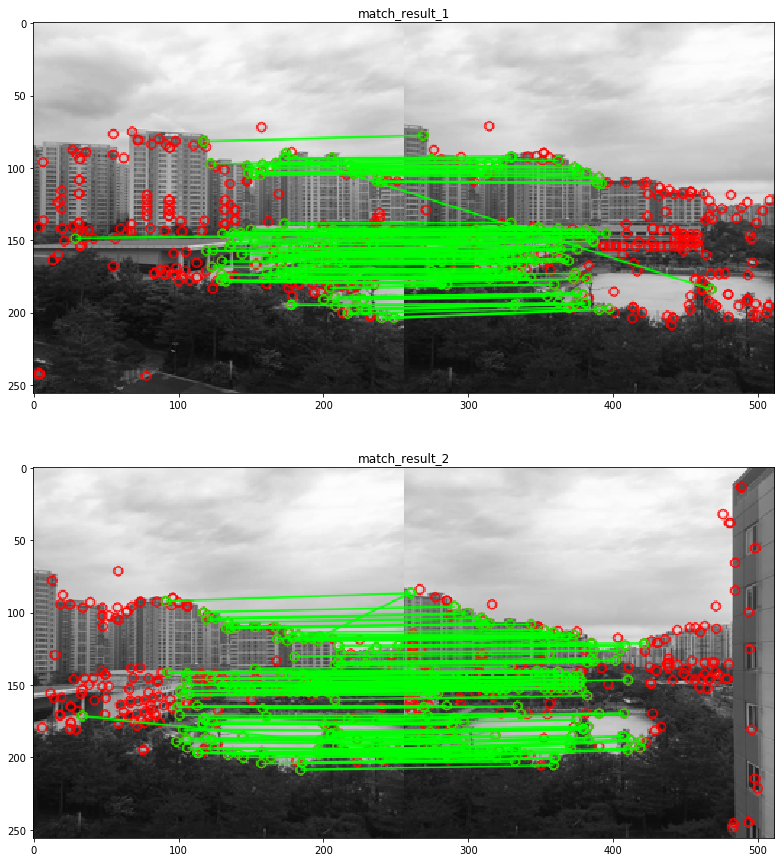

In [115]:
index_params=dict(algorithm=0, trees=5)
search_params=dict(checks=100) 

ANNsearch=cv.FlannBasedMatcher(index_params, search_params)
match1=ANNsearch.knnMatch(d1,d2,k=2)
match2=ANNsearch.knnMatch(d2,d3,k=2)

mask1=[[0,0] for i in range(len(match1))]
mask2=[[0,0] for i in range(len(match2))]


for i,(m,n) in enumerate(match1):
    if m.distance < 0.7*n.distance:
        mask1[i]=[1,0]

        
for i,(m,n) in enumerate(match2):
    if m.distance < 0.7*n.distance:
        mask2[i]=[1,0]

draw_params_1=dict(matchColor=(0,255,0), singlePointColor=(255,0,0), matchesMask=mask1, flags=0)
draw_params_2=dict(matchColor=(0,255,0), singlePointColor=(255,0,0), matchesMask=mask2, flags=0)

match_result_1=cv.drawMatchesKnn(grey_img_1, k1, grey_img_2, k2, match1, None, **draw_params_1)
match_result_2=cv.drawMatchesKnn(grey_img_2, k2, grey_img_3, k3, match2, None, **draw_params_2)

rcParams['figure.figsize'] = 20, 15
plt.subplot(211)
plt.title('match_result_1')
plt.imshow(match_result_1)
plt.subplot(212)
plt.title('match_result_2')
plt.imshow(match_result_2)

RANSAC을 통해 H를 구하는 알고리즘에서 option부분에서 optimal estimation과 guided matching까지 모두 구현하였다. 찾은 inliner 집합을 이용해 H를 찾아내고, 그 H를 이용해 다시 inliner들을 찾아내는데, 여기서 inliner가 더이상 추가되지 않는다면 while 문에서 빠져나오도록 구현하였다.

In [116]:
#DLT algorithm

def DLT(src, des):
    src=np.array(src)
    des=np.array(des)
    n=src.shape[0]
    result=np.zeros((n*2,9))
    for i in range(n):
        result[2*i,:]=[0,0,0,-src[i][0],-src[i][1],-1,src[i][0]*des[i][1],src[i][1]*des[i][1],des[i][1]]
        result[2*i+1,:]=[src[i][0],src[i][1],1,0,0,0,-src[i][0]*des[i][0],-src[i][1]*des[i][0],-des[i][0]]
    U,D,Vh=np.linalg.svd(result, full_matrices=True)
    V=np.transpose(Vh)
    H=V[:, 8].reshape(3, 3)
    H=np.array(H)
    
    
    return H

#distance measure

def dist(x1,x2,H):
    x1=[x1[0],x1[1],1]
    x2=[x2[0],x2[1],1]
    x1_p=np.linalg.inv(H).dot(x2)
    x2_p=H.dot(x1)
    x1_p=x1_p/x1_p[2]
    x2_p=x2_p/x2_p[2]
    
    
    distance=(x1[0]-x1_p[0])**2+(x1[1]-x1_p[1])**2+(x2[0]-x2_p[0])**2+(x2[1]-x2_p[1])**2
    return distance


#RANSAC

RANSAC_t=1.25
RANSAC_p=0.99

def RANSAC(img1, img2):
    
    k1,d1=sift.detectAndCompute(img1,None)
    k2,d2=sift.detectAndCompute(img2,None)
    match=ANNsearch.knnMatch(d1,d2,k=2)

    index_list=[-1 for i in range(280)] ## k1에서 찾음
    max_inliners_flag=[0 for i in range(280)] 

    idx=0 ##개수
    
    for i,(m,n) in enumerate(match):
        if m.distance < 0.7*n.distance:

            index_list[idx]=i
            idx+=1
            
    final_H=np.zeros((3,3))
    max_inliners_count=-1
    N=np.inf
    sample_count=0
    max_total_e=0
    
    
    
    while(N>sample_count):
        total_e=0
        inliners_count=0
        inliners_flag=[0 for i in range(280)] 
        sample_idx=np.random.choice(idx, 4, replace=False)
        src=[k1[match[index_list[sample_idx[i]]][0].queryIdx].pt[::-1] for i in range(4)]
        des=[k2[match[index_list[sample_idx[i]]][0].trainIdx].pt[::-1] for i in range(4)]
        H=DLT(src,des)
        
        for i in range(idx):
            distance=dist(k1[match[index_list[i]][0].queryIdx].pt[::-1],k2[match[index_list[i]][0].trainIdx].pt[::-1],H)
            if distance<=RANSAC_t:
                total_e+=distance
                inliners_count+=1
                inliners_flag[i]=1
        
        if inliners_count>=max_inliners_count:
            max_total_e=total_e
            max_inliners_count=inliners_count
            final_H=np.copy(H)
            max_inliners_flag=np.copy(inliners_flag)
        
        e=1-(max_inliners_count/idx)
        N=np.log(1-RANSAC_p)/np.log(1-(1-e)**4)
        N=np.around(N)
        sample_count+=1
    

    #optimal estimation and guided matching

    final_src=[]
    final_des=[]
    for i in range(idx):
        if(max_inliners_flag[i]==1):
            final_src+=[k1[match[index_list[i]][0].queryIdx].pt[::-1]]
            final_des+=[k2[match[index_list[i]][0].trainIdx].pt[::-1]]
    final_H=DLT(final_src,final_des)
    flag=0
    
    while(1):
        for i in range(idx):
            distance=dist(k1[match[index_list[i]][0].queryIdx].pt[::-1],k2[match[index_list[i]][0].trainIdx].pt[::-1],final_H)
            if distance<=RANSAC_t and max_inliners_flag[i]==0:
                final_src+=[k1[match[index_list[i]][0].queryIdx].pt[::-1]]
                final_des+=[k2[match[index_list[i]][0].trainIdx].pt[::-1]]
                max_inliners_flag[i]=1
                max_inliners_count+=1
                flag=1
        final_H=DLT(final_src,final_des)
        if (flag==0):
            break
        flag=0
    
    print("percentage of inliners = ", max_inliners_count*100/idx,"%")
    print("Homography matrix = \n",final_H)
    return final_H, idx, max_inliners_count, total_e
   
#linear interpolation function

def interpolation(img,x,y):
    a=[int(x),int(y)]
    b=[int(x),int(y)+1]
    c=[int(x)+1,int(y)]
    d=[int(x)+1,int(y)+1]
    temp1=(1-x+int(x))*img[a[0]][a[1]]+(x-int(x))*img[c[0]][c[1]]
    temp2=(1-x+int(x))*img[b[0]][b[1]]+(x-int(x))*img[b[0]][b[1]]
    result=(1-y+int(y))*temp1+(y-int(y))*temp2
    result=np.around(result)
    return result

In [117]:
H12, m12, c12, e12=RANSAC(grey_img_1, grey_img_2) #Homography matrices 들을 구하는 function
H21, m21, c21, e21=RANSAC(grey_img_2, grey_img_1)
H32, m32, c32, e32=RANSAC(grey_img_3, grey_img_2)
H23, m23, c23, e23=RANSAC(grey_img_2, grey_img_3)

percentage of inliners =  90.0990099009901 %
Homography matrix = 
 [[-8.34216477e-03 -1.45319962e-03  2.68581772e-01]
 [ 1.23394535e-04 -9.14895291e-03  9.63155571e-01]
 [-2.74015674e-07 -1.09689727e-05 -6.30520167e-03]]
percentage of inliners =  88.23529411764706 %
Homography matrix = 
 [[ 8.36483677e-03 -1.47449652e-03  1.29861155e-01]
 [ 4.74239078e-05  6.47102725e-03  9.91430193e-01]
 [-5.64440997e-07 -1.11154512e-05  9.39315104e-03]]
percentage of inliners =  98.4 %
Homography matrix = 
 [[-1.01599377e-02  1.47130430e-03 -1.69097676e-01]
 [-6.14701871e-06 -8.46644367e-03 -9.85443754e-01]
 [ 9.51758915e-07  1.07694882e-05 -1.13804160e-02]]
percentage of inliners =  96.15384615384616 %
Homography matrix = 
 [[-1.02683649e-02 -1.43565767e-03  2.72975240e-01]
 [ 1.09261611e-04 -1.11468779e-02  9.61864824e-01]
 [-6.39601170e-07 -1.07060088e-05 -8.29542463e-03]]


optimal estimation과 guided matching을 이용한 결과 RANSAC은 근본적으로 random하게 추출함에도 불구하고 안정적으로 최대한 많은 inliner들을 뽑아낼 수 있었다. 구현한 함수를 여러번 시행해서 결과를 확인해도 최종 inliner의 숫자와 H가 크게 바뀌지 않는것을 확인할 수 있다.

In [118]:
final_img_1=np.array([[255 for i in range(800)] for j in range(400)]) ##offset= 72,272 더해주기
final_img_2=np.array([[255 for i in range(800)] for j in range(400)]) 
final_img_3=np.array([[255 for i in range(800)] for j in range(400)])
final_output=np.array([[255 for i in range(800)] for j in range(400)])

In [119]:
for i in range(256):
    for j in range(256):
        final_img_2[i+72][j+272]=grey_img_2[i][j]

In [120]:
#backward warping

def backward_1(img):
    temp=np.array([[255 for i in range(800)] for j in range(400)])
    for i in range(400):
        for j in range(800):
            coord=[i-72,j-272,1]
            org_coord=H21.dot(coord)
            org_coord=org_coord/org_coord[2]
            if(org_coord[0]>0 and org_coord[0]<255 and org_coord[1]>0 and org_coord[1]<255):
                temp[i][j]=interpolation(img,org_coord[0],org_coord[1])
    return temp

def backward_3(img):
    temp=np.array([[255 for i in range(800)] for j in range(400)])
    for i in range(400):
        for j in range(800):
            coord=[i-72,j-272,1]
            org_coord=H23.dot(coord)
            org_coord=org_coord/org_coord[2]
            if(org_coord[0]>0 and org_coord[0]<255 and org_coord[1]>0 and org_coord[1]<255):
                temp[i][j]=interpolation(img,org_coord[0],org_coord[1])
    return temp

In [121]:
final_img_1=np.copy(backward_1(grey_img_1))
final_img_3=np.copy(backward_3(grey_img_3))

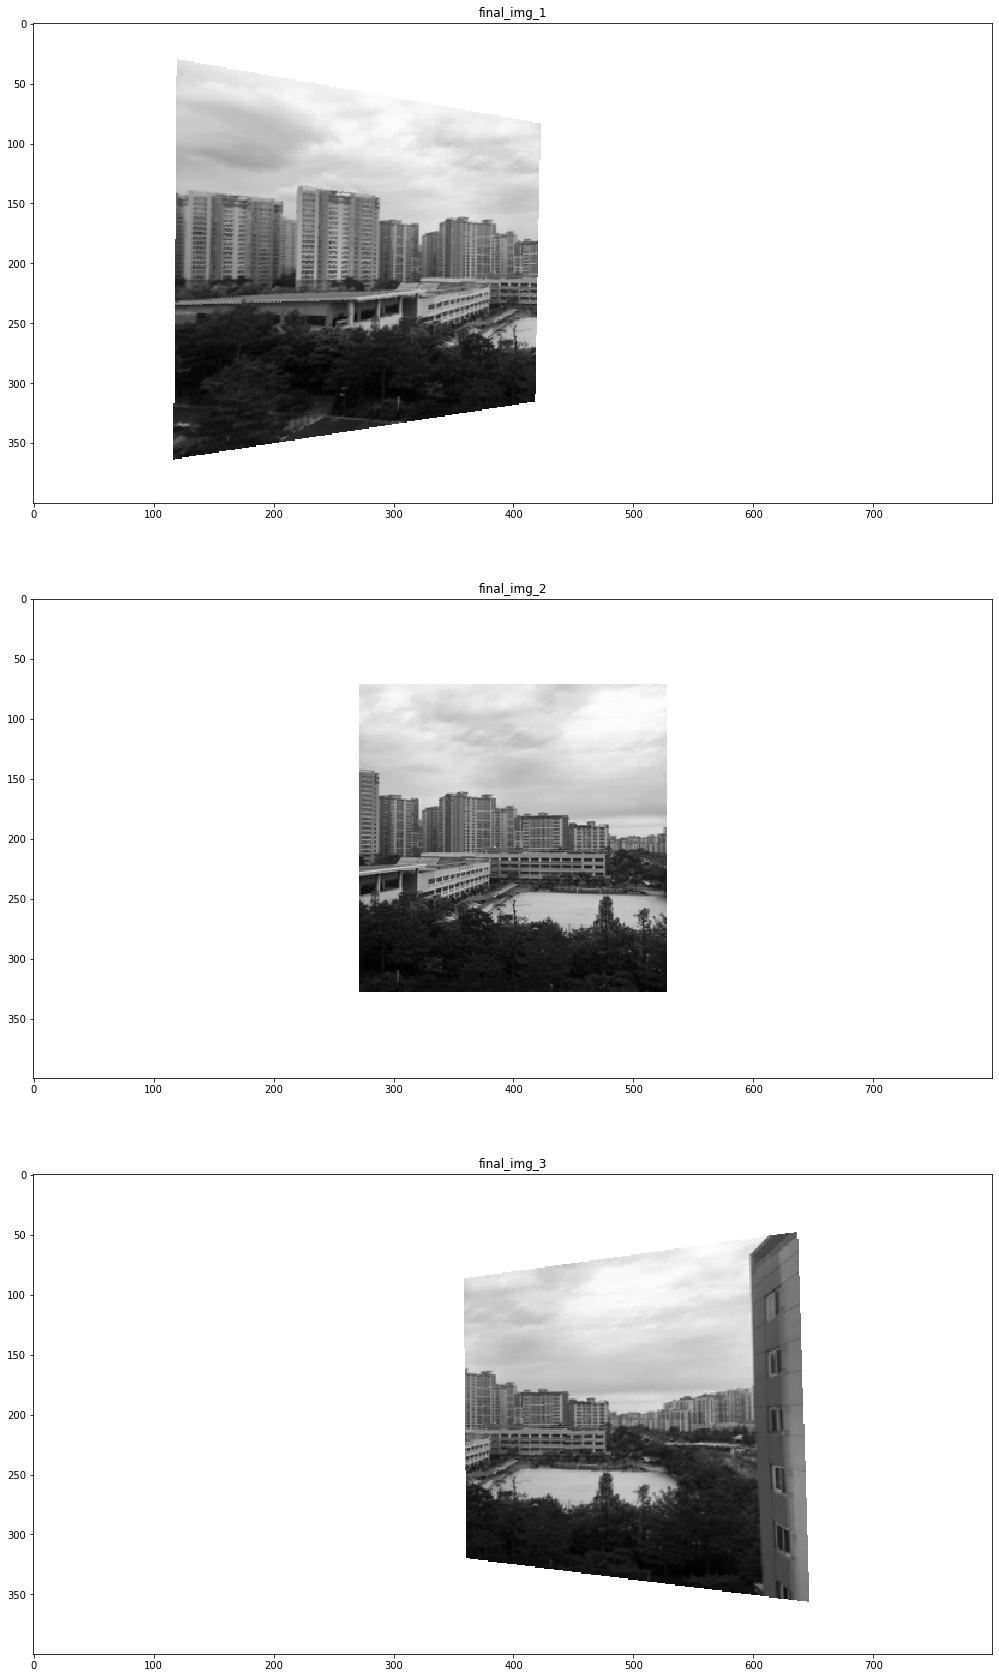

In [122]:
rcParams['figure.figsize'] = 50, 30
plt.subplot(3,1,1)
plt.title('final_img_1')
plt.imshow(final_img_1, cmap='gray')
plt.subplot(3,1,2)
plt.title('final_img_2')
plt.imshow(final_img_2, cmap='gray')
plt.subplot(3,1,3)
plt.title('final_img_3')
plt.imshow(final_img_3, cmap='gray')


In [123]:
def toFinal(final_img_1,final_img_2,final_img_3):
    final_output=np.array([[255 for i in range(800)] for j in range(400)])
    for i in range(400):
        for j in range(800):
            if (final_img_1[i][j]!=255 and final_img_2[i][j]!=255 and final_img_3[i][j]!=255):
                final_output[i][j]=np.around((final_img_1[i][j]+final_img_2[i][j]+final_img_3[i][j])/3)
            if (final_img_1[i][j]!=255 and final_img_2[i][j]!=255 and final_img_3[i][j]==255):
                final_output[i][j]=np.around((final_img_1[i][j]+final_img_2[i][j])/2)
            if (final_img_1[i][j]!=255 and final_img_2[i][j]==255 and final_img_3[i][j]!=255):
                final_output[i][j]=np.around((final_img_1[i][j]+final_img_3[i][j])/2)
            if (final_img_1[i][j]==255 and final_img_2[i][j]!=255 and final_img_3[i][j]!=255):
                final_output[i][j]=np.around((final_img_2[i][j]+final_img_3[i][j])/2)
            if (final_img_1[i][j]!=255 and final_img_2[i][j]==255 and final_img_3[i][j]==255):
                final_output[i][j]=final_img_1[i][j]
            if (final_img_1[i][j]==255 and final_img_2[i][j]!=255 and final_img_3[i][j]==255):
                final_output[i][j]=final_img_2[i][j]
            if (final_img_1[i][j]==255 and final_img_2[i][j]==255 and final_img_3[i][j]!=255):
                final_output[i][j]=final_img_3[i][j]
    return final_output

In [124]:
final_output=np.copy(toFinal(final_img_1,final_img_2,final_img_3))

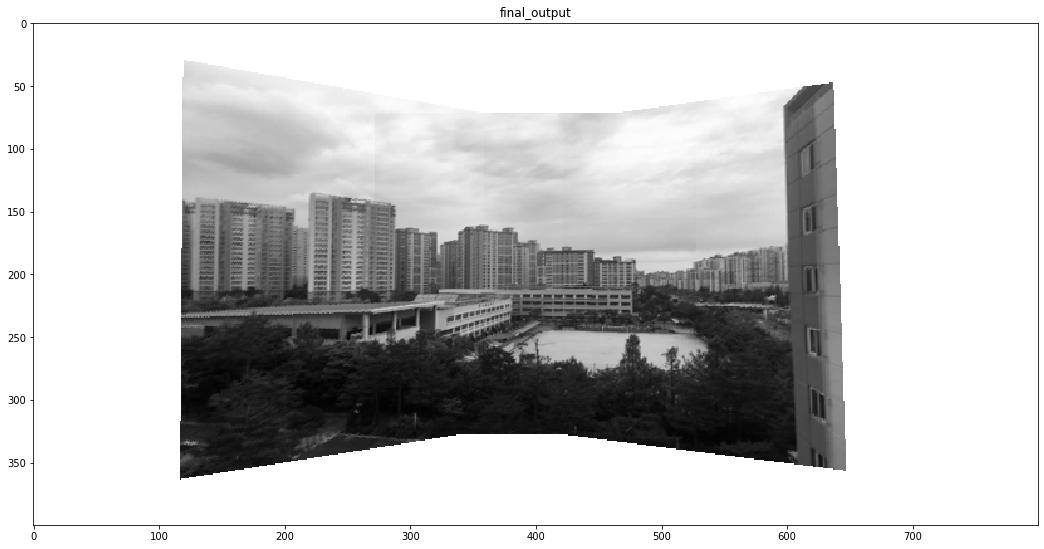

In [125]:
rcParams['figure.figsize'] = 18, 10
plt.title('final_output')
plt.imshow(final_output, cmap='gray')

In [126]:
# creating RGB image

final_img_1_R=np.array([[255 for i in range(800)] for j in range(400)])
final_img_2_R=np.array([[255 for i in range(800)] for j in range(400)]) 
final_img_3_R=np.array([[255 for i in range(800)] for j in range(400)])
final_output_R=np.array([[255 for i in range(800)] for j in range(400)])
final_img_1_G=np.array([[255 for i in range(800)] for j in range(400)])
final_img_2_G=np.array([[255 for i in range(800)] for j in range(400)]) 
final_img_3_G=np.array([[255 for i in range(800)] for j in range(400)])
final_output_G=np.array([[255 for i in range(800)] for j in range(400)])
final_img_1_B=np.array([[255 for i in range(800)] for j in range(400)])
final_img_2_B=np.array([[255 for i in range(800)] for j in range(400)]) 
final_img_3_B=np.array([[255 for i in range(800)] for j in range(400)])
final_output_B=np.array([[255 for i in range(800)] for j in range(400)])

for i in range(256):
    for j in range(256):
        final_img_2_R[i+72][j+272]=img_2_arr[:,:,0][i][j]
for i in range(256):
    for j in range(256):
        final_img_2_G[i+72][j+272]=img_2_arr[:,:,1][i][j]
for i in range(256):
    for j in range(256):
        final_img_2_B[i+72][j+272]=img_2_arr[:,:,2][i][j]

final_img_1_R=np.copy(backward_1(img_1_arr[:,:,0]))        
final_img_1_G=np.copy(backward_1(img_1_arr[:,:,1]))       
final_img_1_B=np.copy(backward_1(img_1_arr[:,:,2]))
final_img_3_R=np.copy(backward_3(img_3_arr[:,:,0]))
final_img_3_G=np.copy(backward_3(img_3_arr[:,:,1]))
final_img_3_B=np.copy(backward_3(img_3_arr[:,:,2]))
final_output_R=np.copy(toFinal(final_img_1_R,final_img_2_R,final_img_3_R))
final_output_G=np.copy(toFinal(final_img_1_G,final_img_2_G,final_img_3_G))
final_output_B=np.copy(toFinal(final_img_1_B,final_img_2_B,final_img_3_B))

In [127]:
final_RGB_image=np.zeros((400,800,3))
final_RGB_image[:,:,0]=final_output_R
final_RGB_image[:,:,1]=final_output_G
final_RGB_image[:,:,2]=final_output_B

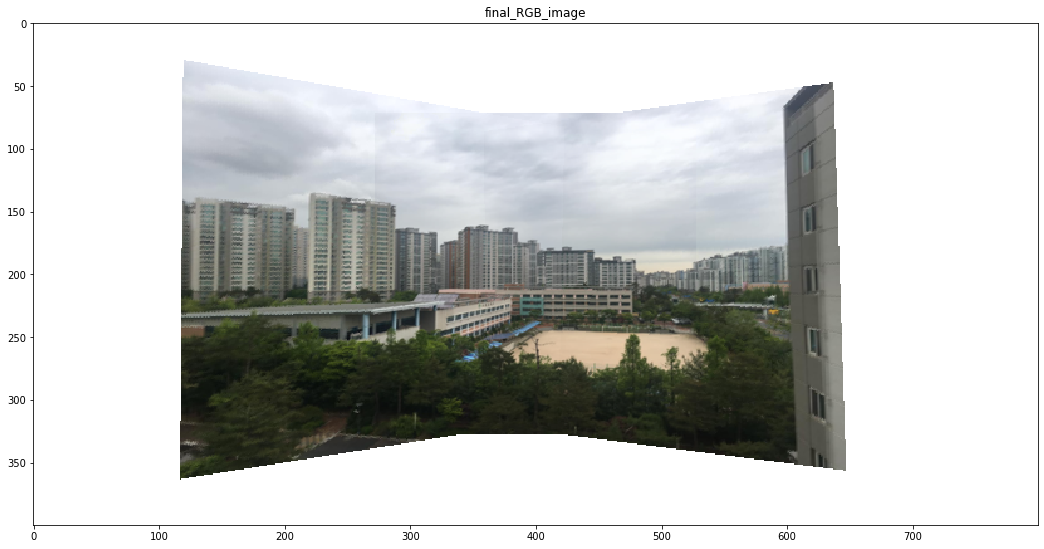

In [128]:
rcParams['figure.figsize'] = 18, 10
plt.title('final_RGB_image')
final_RGB_image/=255
plt.imshow(final_RGB_image)

In [129]:
print("Homography matrices")
print("H12 = ",H12)
print("H32 = ",H32)

Homography matrices
H12 =  [[-8.34216477e-03 -1.45319962e-03  2.68581772e-01]
 [ 1.23394535e-04 -9.14895291e-03  9.63155571e-01]
 [-2.74015674e-07 -1.09689727e-05 -6.30520167e-03]]
H32 =  [[-1.01599377e-02  1.47130430e-03 -1.69097676e-01]
 [-6.14701871e-06 -8.46644367e-03 -9.85443754e-01]
 [ 9.51758915e-07  1.07694882e-05 -1.13804160e-02]]


In [130]:
print("문제에서는 H12, H32를 기준으로 말하였지만 backward warping은 결국 H21, H23를 사용하므로 이들을 기준으로 작성하겠다\n")
print("Homography matrices")
print("H21 = ",H21)
print("H23 = ",H23)
print("\nPercentage of maximum inliers for each H")
print("H21 = ",c21*100/m21,"%")
print("H23 = ",c23*100/m23,"%")
print("\nTotal average symmetric transfer error for each H for total inliners")
print("H21 average inliners transfer error = ",e21/c21)
print("H23 average inliners transfer error =",e23/c23)

문제에서는 H12, H32를 기준으로 말하였지만 backward warping은 결국 H21, H23를 사용하므로 이들을 기준으로 작성하겠다

Homography matrices
H21 =  [[ 8.36483677e-03 -1.47449652e-03  1.29861155e-01]
 [ 4.74239078e-05  6.47102725e-03  9.91430193e-01]
 [-5.64440997e-07 -1.11154512e-05  9.39315104e-03]]
H23 =  [[-1.02683649e-02 -1.43565767e-03  2.72975240e-01]
 [ 1.09261611e-04 -1.11468779e-02  9.61864824e-01]
 [-6.39601170e-07 -1.07060088e-05 -8.29542463e-03]]

Percentage of maximum inliers for each H
H21 =  88.23529411764706 %
H23 =  96.15384615384616 %

Total average symmetric transfer error for each H for total inliners
H21 average inliners transfer error =  0.13870098866631628
H23 average inliners transfer error = 0.2138206477895532


전체적으로 상당히 깨끗한 이미지를 얻을 수 있었다. 특히 optimal estiamtion과 guided matching을 이용하여 RANSAC은 랜덤으로 추출해서 시험함에도 불구하고 안정적이고 적절하게 필요한 inliner들을 찾아내어 homography matrix를 구하는데 사용할 수 있었다. 다만 살짝 아쉬운점은 카메라의 방향에 따라 렌즈로 들어오는 빛의 양이 달라지고 같은 물체일지라도 밝기가 달라지기 때문에 사진이 겹치는 부분들의 테두리(edge)에 희미한 선이 보인다. 이는 전반적인 밝기 차에 의한것이므로 interpolation으로는 해결되지 않는다. 이를 해결하기 위해서는 한 image를 기준으로 잡고 밝기에 대해 전체적으로 scaling 해주면 이러한 edge들을 없앨 수 있지 않을까 추측한다. 사실 이러한 파노라마 이미지를 만드는 과정은 3차원인 지구를 2차원으로 투영하는 작업이기도 하다. 따라서 필연적으로 이미지에 왜곡이 발생할 수 밖에 없는데 이러한 왜곡을 효과적으로 다루는 방법이나, 분산된 2D이미지를 이용해 VR이미지를 만드는 작업을 추후에 연구해보고싶다

아래는 256x256 이미지가 아닌 700x700이미지로 변환하여 좀더 고화질인 사진을 얻은 결과이다(코드를 수정하여 계산하였다). 700x700으로 계산하여 시간은 몇배이상 오래걸리긴 하였다. 그러나 볼 수 있듯이 높은 화질을 가진 이미지로 계산하여도 훌륭한 결과를 얻을 수 있다는것을 확인하였다.

In [131]:
image_infront_1=Image.open('image_infront_1.jpg')
image_infront_2=Image.open('image_infront_2.jpg')
image_infront_3=Image.open('image_infront_3.jpg')
image_highres_result=Image.open('image_highres_result.png')

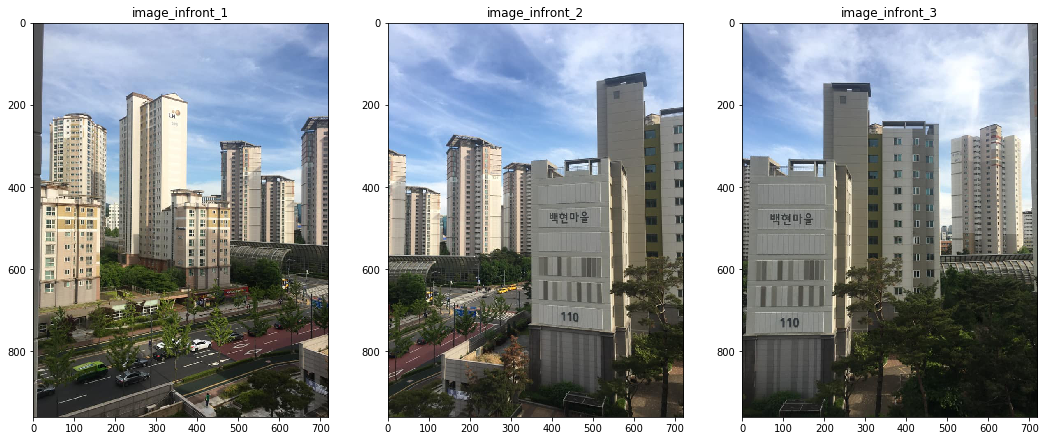

In [132]:
plt.subplot(131)
plt.title('image_infront_1')
plt.imshow(image_infront_1)
plt.subplot(132)
plt.title('image_infront_2')
plt.imshow(image_infront_2)
plt.subplot(133)
plt.title('image_infront_3')
plt.imshow(image_infront_3)


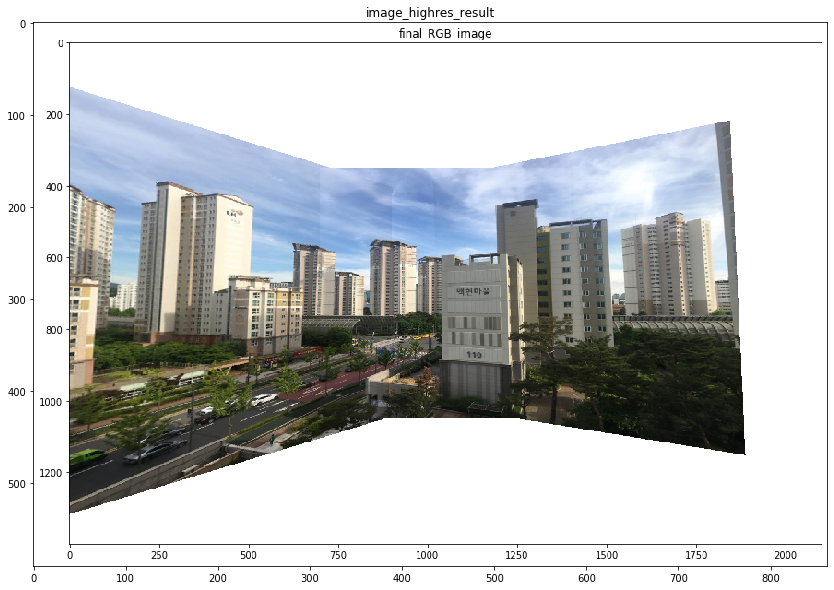

In [133]:
plt.title('image_highres_result')
plt.imshow(image_highres_result)